In [27]:
# %pip install pandas numpy imageio seaborn matplotlib scipy ipympl scikit-learn

In [28]:
from pathlib import Path
import math
from typing import Tuple, Sequence

import pandas as pd
import imageio.v3 as iio
import seaborn as sns; sns.set()
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import numpy as np
from scipy.spatial.distance import cdist, euclidean
from scipy.stats import lognorm

def geometric_median(X, eps=1e-5):
    """
    Adapted from https://stackoverflow.com/questions/30299267/geometric-median-of-multidimensional-points
    """
    
    y = np.mean(X, 0)

    while True:
        D = cdist(X, [y])
        nonzeros = (D != 0)[:, 0]

        Dinv = 1 / D[nonzeros]
        Dinvs = np.sum(Dinv)
        W = Dinv / Dinvs
        T = np.sum(W * X[nonzeros], 0)

        num_zeros = len(X) - np.sum(nonzeros)
        if num_zeros == 0:
            y1 = T
        elif num_zeros == len(X):
            return y
        else:
            R = (T - y) * Dinvs
            r = np.linalg.norm(R)
            rinv = 0 if r == 0 else num_zeros/r
            y1 = max(0, 1-rinv)*T + min(1, rinv)*y

        if euclidean(y, y1) < eps:
            return y1

        y = y1

def median_of_distances(X, geometric_median) -> float:
    distances = [math.sqrt(sum((value - median_value) ** 2 for value, median_value in zip(sample, geometric_median))) for sample in X]
    return np.median(distances)

class Image:
    def __init__(self, name: str):
        file = next(Path("/data/facets/data").rglob(f"*{name}"))
        self.image = iio.imread(str(file))

    def plot_to(self, ax):
        ax.imshow(self.image, cmap="gray")
        ax.axis("off")

    def plot_distance_contour_to(self, ax, center: Tuple[float, float], color_map, threshold: float = 1.0, levels: Sequence[float] = None, plot_legend: bool = False):
        if isinstance(levels, int):
            levels = np.linspace(0, threshold, levels, endpoint=True)
        
        x = np.arange(0.0, self.image.shape[0], 1)
        y = np.arange(0.0, self.image.shape[1], 1)
        xv, yv = np.meshgrid(x, y)

        distances = np.sqrt((xv - center[0]) ** 2 + (yv - center[1]) ** 2)
        contour = ax.contourf(xv, yv, distances, vmin=0, vmax=threshold, levels=levels, alpha=0.3, cmap=color_map);
        if plot_legend:
            ax.figure.colorbar(contour, ax=ax)


## Analyse the output of the individual detectors

In [29]:
results = pd.read_csv("/data/facets/data/result.tsv", sep="\t").set_index("File")
results["Detector"] = results["Detector"].replace({
    "bore:0.1": "Fuhl et al (2018)",
    "cprd:0.1": "Wan et al (2021)",
    "edgeguided:0.1": "Wang et al (2021)",
    "ellseg:0.1": "Kothari et al. (2021)",
    "else:0.1": "Fuhl et al. (2016)",
    "excuse:0.1": "Fuhl et al. (2015)",
    "pupilellipsefiterror:0.1": "Akinlar, Kucukkartal, and Topal (2022)",
    "pupillabs:0.1": "Kassner, Patera, and Bulling (2014)",
    "pupillocator:0.1": "Eivazi et al. (2019)",
    "pure:0.1": "Santini, Fuhl, and Kasneci (2018)",
    "starburst:0.1": "Li, Winfield, and Parkhurst (2005)",
    "swirski:0.1": "Swirski, Bulling, and Dodgson (2012)",
    "timms:0.1": "Krause, and Essig (2019)"
})

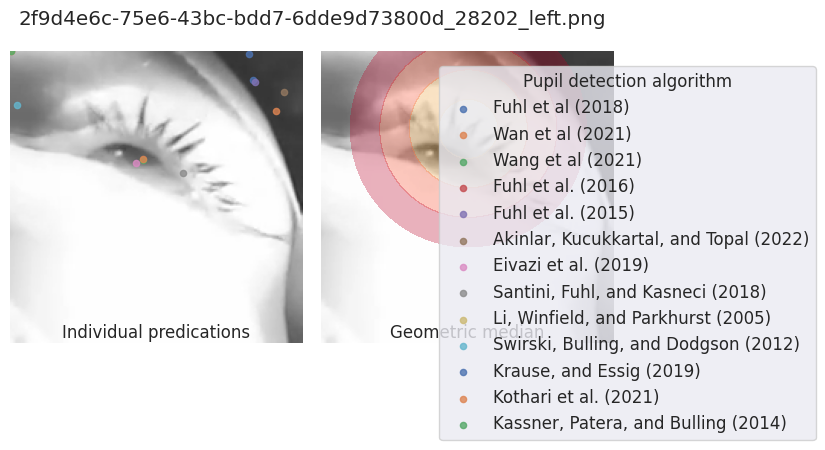

In [30]:
def calculate_uncertainty(distances, geometric_median, values: np.ndarray, uncertainty_factor: float) -> np.ndarray:
    median_of_distances_to_mg = median_of_distances(values, geometric_median)
    return distances / median_of_distances_to_mg * uncertainty_factor
    
#FILE = "0637fc4a-23c5-48b5-9e98-5c174fbbc615_17031_left_badquality.png"
FILE = "2f9d4e6c-75e6-43bc-bdd7-6dde9d73800d_28202_left.png"
COLOR_MAP = mpl.colormaps['YlOrRd']
TEXT_STYLE = { 'fontname': 'DejaVu Sans' }

img = Image(FILE)
fig, (ax1, ax2) = plt.subplots(1, 2)

# Visualize the individual responses
img.plot_to(ax1)
for value in results.loc[FILE].itertuples():
    if value.X > img.image.shape[0] or value.Y > img.image.shape[1]:
        print(f"{value.Detector} discarded")
        continue
    ax1.scatter(x=[value.X], y=[value.Y], s=20, label=value.Detector, alpha=0.8)
ax1.set_title("Individual predications", y=-0.01, **TEXT_STYLE)

values = results.loc[FILE, ["X", "Y"]].to_numpy()
median_value = geometric_median(values)

img.plot_to(ax2)

median_of_distances_to_mg = median_of_distances(values, median_value)
img.plot_distance_contour_to(ax2, center=median_value, levels=5, threshold=median_of_distances_to_mg, color_map=COLOR_MAP, plot_legend=False)
ax2.set_title("Geometric median", y=-0.01, **TEXT_STYLE)

fig.suptitle(FILE, y=0.85, **TEXT_STYLE)
fig.tight_layout()
fig.legend(title="Pupil detection algorithm", bbox_to_anchor=(1.3, 0.75), prop=font_manager.FontProperties(family=TEXT_STYLE["fontname"]))
fig.show()


,Name,Label,Median spread
18,4e9af4e0-ff20-4131-bdfa-35507b4d8e7b_18707_rig...,Valid,88.138555
69,0bdc64d3-6f7b-419f-b51f-7ec6a0089b92_19637_rig...,Valid,59.539892
77,0bdc64d3-6f7b-419f-b51f-7ec6a0089b92_23517_lef...,Valid,13.968764
78,0bdc64d3-6f7b-419f-b51f-7ec6a0089b92_23534_rig...,Valid,19.104930
79,0bdc64d3-6f7b-419f-b51f-7ec6a0089b92_24585_lef...,Valid,16.905411
81,0bdc64d3-6f7b-419f-b51f-7ec6a0089b92_24663_lef...,Valid,13.358024
83,0bdc64d3-6f7b-419f-b51f-7ec6a0089b92_48464_lef...,Valid,57.980202
85,0bdc64d3-6f7b-419f-b51f-7ec6a0089b92_50676_rig...,Valid,42.895038
88,0bdc64d3-6f7b-419f-b51f-7ec6a0089b92_54019_lef...,Valid,10.412707
128,2b250d43-e45f-4d92-a647-ad0d25a73736_25739_rig...,Valid,15.772814


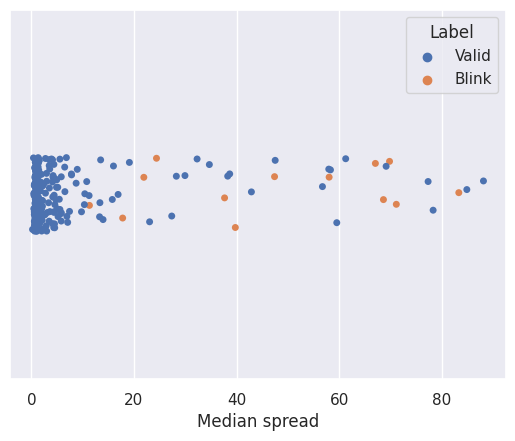

In [31]:
CLOSED_EYES = [
    "0bdc64d3-6f7b-419f-b51f-7ec6a0089b92_11947_right.png",
    "0bdc64d3-6f7b-419f-b51f-7ec6a0089b92_11950_left.png",
    "1e30405a-a4c8-4692-95ca-00cf2212218f_23277_right.png",
    "1e30405a-a4c8-4692-95ca-00cf2212218f_23317_left.png",
    "1e30405a-a4c8-4692-95ca-00cf2212218f_26100_left.png", # Half
    "2b250d43-e45f-4d92-a647-ad0d25a73736_20721_right.png",
    "2b250d43-e45f-4d92-a647-ad0d25a73736_20785_left.png",
    "2b250d43-e45f-4d92-a647-ad0d25a73736_20801_right.png",
    "2f9d4e6c-75e6-43bc-bdd7-6dde9d73800d_37698_right.png",
    "2f9d4e6c-75e6-43bc-bdd7-6dde9d73800d_37721_left.png",
    "2f9d4e6c-75e6-43bc-bdd7-6dde9d73800d_28169_right.png" # Semi hard
    "4e9af4e0-ff20-4131-bdfa-35507b4d8e7b_20354_right.png",
    "4e9af4e0-ff20-4131-bdfa-35507b4d8e7b_20362_left.png",
    "4e9af4e0-ff20-4131-bdfa-35507b4d8e7b_25909_right.png", # Semi hard
    "4e9af4e0-ff20-4131-bdfa-35507b4d8e7b_25932_left.png" # Semi hard,
    "08fde77b-d597-49a7-8a7c-f3a18ea4409a_24373_left.png",
    "08fde77b-d597-49a7-8a7c-f3a18ea4409a_24382_right.png"
]

folders = set([f"{folder.split('_')[0]}_eyeExport" for folder in CLOSED_EYES])
samples = []
for folder in folders:
    for file in (Path("/data/facets/data") / folder).glob("*.png"):
        label = "Blink" if file.name in CLOSED_EYES else "Valid"
        
        values = results.loc[file.name, ["X", "Y"]].to_numpy()
        median_value = geometric_median(values)
        median_spread = median_of_distances(values, median_value)

        samples.append(
            (file.name, label, median_spread)
        )
    
samples = pd.DataFrame.from_records(samples, columns=["Name", "Label", "Median spread"])
sns.stripplot(data=samples, x="Median spread", hue="Label")

samples[(samples["Median spread"] > 10) & (samples["Label"] == "Valid")]

## Working with labeled data

In [32]:
OUTPUT_PATH = Path("/data/facets/data_annotated")

import shutil
import random

PATTERNS = ["*left_max.png", "*right_max.png"]
if not OUTPUT_PATH.is_dir():
    rng = random.Random(42)
    OUTPUT_PATH.mkdir(parents=True, exist_ok=False)
    for path in Path("/data/facets/data").glob("*"):
        if not path.is_dir():
            continue
        for pattern in PATTERNS:
            image_paths = list(path.glob(pattern))
            if len(image_paths) == 0:
                continue
            image_path: Path = rng.choice(image_paths)
            print(image_path)
            shutil.copy(image_path, OUTPUT_PATH / image_path.name)

In [33]:
import json

annotated_data = []
for annotation in (OUTPUT_PATH / "annotations").glob("*.json"):
    with annotation.open("r") as annotation_data:
        annotation_data = json.load(annotation_data)
    
        # Parste the center
        center = annotation_data["shapes"][0]
        is_well_defined = center["label"] == "PupilCenter"
        center = center["points"][0]

        annotated_data.append((annotation.stem + ".png", center[0], center[1], is_well_defined))

annotated_data.extend([
    ("0bdc64d3-6f7b-419f-b51f-7ec6a0089b92_17209_left.png", 70, 22, True),
    ("1cfbe940-9389-40f6-9225-cad2cff35451_17629_left.png", 71, 55, True),
    ("1e30405a-a4c8-4692-95ca-00cf2212218f_17196_left.png", 58, 42, True),
    ("2b250d43-e45f-4d92-a647-ad0d25a73736_17088_right.png", 85, 97, True),
    ("2f9d4e6c-75e6-43bc-bdd7-6dde9d73800d_17678_right.png", 127, 73, True),
    ("2f9d4e6c-75e6-43bc-bdd7-6dde9d73800d_18667_right.png", 177, 74, False), # Hard
])

annotated_data = pd.DataFrame.from_records(annotated_data, index="File", columns=["File", "X", "Y", "WellDefined"])
assert annotated_data.index.is_unique, "Files not unique"

annotated_data

,X,Y,WellDefined
File,,,
0637fc4a-23c5-48b5-9e98-5c174fbbc615_17908_right.png,109.121272,64.190855,True
0637fc4a-23c5-48b5-9e98-5c174fbbc615_18186_left.png,61.606362,59.220676,True
0637fc4a-23c5-48b5-9e98-5c174fbbc615_49271_right_max.png,108.524851,69.359841,True
0637fc4a-23c5-48b5-9e98-5c174fbbc615_49359_left_max.png,68.166998,53.455268,True
08fde77b-d597-49a7-8a7c-f3a18ea4409a_18566_right.png,112.898608,87.053678,True
...,...,...,...
1cfbe940-9389-40f6-9225-cad2cff35451_17629_left.png,71.000000,55.000000,True
1e30405a-a4c8-4692-95ca-00cf2212218f_17196_left.png,58.000000,42.000000,True
2b250d43-e45f-4d92-a647-ad0d25a73736_17088_right.png,85.000000,97.000000,True


### Visualize the definition of "error"

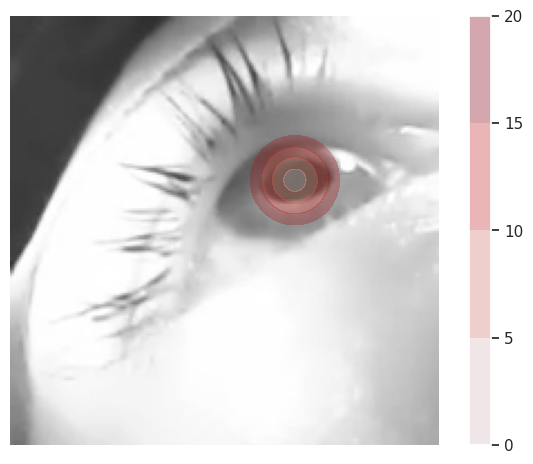

In [34]:
FILE = "2f9d4e6c-75e6-43bc-bdd7-6dde9d73800d_17678_right.png"
ERROR_TRHESHOLD = [0, 5, 10, 15, 20]
COLOR_MAP = mpl.colormaps['Reds']

img = Image(FILE)
center = annotated_data.loc[FILE][["X", "Y"]].to_numpy()

fig, ax = plt.subplots(1, 1)
img.plot_to(ax)
img.plot_distance_contour_to(ax, center=center, threshold=20, levels=[0, 5, 10, 15, 20], color_map=COLOR_MAP, plot_legend=True)

fig.tight_layout()
fig.savefig("error_impact.png", dpi=500)

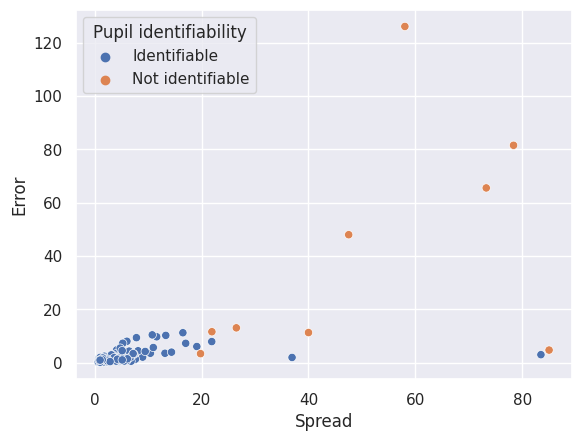

In [35]:
from scipy.spatial.distance import euclidean

annotated_files_with_errors = []
pupil_detectors = list(results["Detector"].unique())

for annotated_sample in annotated_data.itertuples():
    subset = results.loc[annotated_sample.Index]

    # Calculate median
    annotated_center = [annotated_sample.X, annotated_sample.Y]
    predictions = subset[["X", "Y"]].to_numpy()
    median_value = geometric_median(predictions)
    median_spread = median_of_distances(predictions, median_value)
    median_distance_from_annotation = euclidean(annotated_center, median_value)

    # Calculate the pupil detectors
    pupil_detectors_error = [
        euclidean(
            annotated_center, 
            subset[subset["Detector"] == detector][["X", "Y"]].to_numpy().flatten()
        )
        for detector in pupil_detectors
    ]

    annotated_files_with_errors.append((
        file, 
        median_distance_from_annotation, 
        median_spread, 
        "Identifiable" if annotated_sample.WellDefined else "Not identifiable", 
        *pupil_detectors_error
    ))

annotated_files_with_errors = pd.DataFrame.from_records(annotated_files_with_errors, columns=["File", "Error", "Spread", "Pupil identifiability", *pupil_detectors])
ax = sns.scatterplot(annotated_files_with_errors, x="Spread", y="Error", hue="Pupil identifiability")

### Evaluate errors and ensembles

In [36]:
pupil_detector_errors = pd.melt(
    annotated_files_with_errors, 
    value_vars=pupil_detectors, 
    id_vars=["File"], 
    var_name="Detector", 
    value_name="Pixel error"
)

pupil_detector_errors

,File,Detector,Pixel error
0,/data/facets/data/2f9d4e6c-75e6-43bc-bdd7-6dde...,Fuhl et al (2018),2.224354
1,/data/facets/data/2f9d4e6c-75e6-43bc-bdd7-6dde...,Fuhl et al (2018),2.017535
2,/data/facets/data/2f9d4e6c-75e6-43bc-bdd7-6dde...,Fuhl et al (2018),5.059230
3,/data/facets/data/2f9d4e6c-75e6-43bc-bdd7-6dde...,Fuhl et al (2018),2.610304
4,/data/facets/data/2f9d4e6c-75e6-43bc-bdd7-6dde...,Fuhl et al (2018),121.351474
...,...,...,...
2283,/data/facets/data/2f9d4e6c-75e6-43bc-bdd7-6dde...,"Kassner, Patera, and Bulling (2014)",0.636354
2284,/data/facets/data/2f9d4e6c-75e6-43bc-bdd7-6dde...,"Kassner, Patera, and Bulling (2014)",1.366816
2285,/data/facets/data/2f9d4e6c-75e6-43bc-bdd7-6dde...,"Kassner, Patera, and Bulling (2014)",0.737725
2286,/data/facets/data/2f9d4e6c-75e6-43bc-bdd7-6dde...,"Kassner, Patera, and Bulling (2014)",1.171946


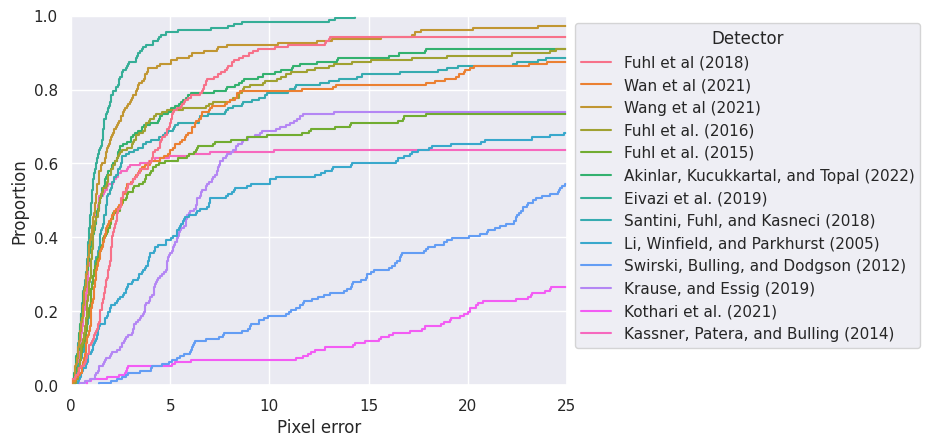

In [37]:
#Empirical CDF

ax = sns.ecdfplot(
    data=pupil_detector_errors, 
    x="Pixel error", 
    hue="Detector", 
    palette=sns.color_palette("husl", len(pupil_detectors))
)
ax.set_xlim(0, 25)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.savefig('error_ecdf.png', bbox_inches='tight', dpi=500)

In [38]:
from scipy.stats import ks_2samp

# https://stats.stackexchange.com/questions/448687/interpreting-scipy-stats-ks-2samp-and-mannwhitneyu-give-conflicting-results
ks_2samp(
    pupil_detector_errors[pupil_detector_errors["Detector"] == "Eivazi et al. (2019)"]["Pixel error"].to_numpy(),
    pupil_detector_errors[pupil_detector_errors["Detector"] == "Kassner, Patera, and Bulling (2014)"]["Pixel error"].to_numpy(),
    alternative="greater"
)

KstestResult(statistic=0.36363636363636365, pvalue=4.87615933248942e-11, statistic_location=14.290826242737197, statistic_sign=1)

In [39]:
detector_rating = pupil_detector_errors.groupby("Detector")["Pixel error"].median().sort_values()
detector_rating

Detector
Eivazi et al. (2019)                       1.042700
Wang et al (2021)                          1.250061
Kassner, Patera, and Bulling (2014)        1.399324
Fuhl et al. (2016)                         1.465767
Akinlar, Kucukkartal, and Topal (2022)     1.473601
Santini, Fuhl, and Kasneci (2018)          1.795711
Fuhl et al (2018)                          2.536249
Wan et al (2021)                           2.573803
Fuhl et al. (2015)                         2.699751
Krause, and Essig (2019)                   6.365921
Li, Winfield, and Parkhurst (2005)         7.007034
Swirski, Bulling, and Dodgson (2012)      23.339915
Kothari et al. (2021)                     51.043415
Name: Pixel error, dtype: float64

In [40]:
current_ensemble = []
results_distances_ensemble = []
for detector, _ in detector_rating.items():
    current_ensemble.append(detector)
    
    # Identify those files both annotated by human being and the current detectors
    annotated_filenames = set(
        results[results["Detector"].isin(current_ensemble)].index.unique()
    ).intersection(annotated_data.index)

    for file, predictions in results[
        results["Detector"].isin(current_ensemble) & results.index.isin(annotated_filenames)
    ].groupby("File"):
        ground_truth = annotated_data.loc[file][["X", "Y"]].to_numpy()
        median_value = geometric_median(predictions[["X", "Y"]].to_numpy()) 
        results_distances_ensemble.append(
            (file, len(current_ensemble), euclidean(ground_truth, median_value))
        )
        
results_distances_ensemble = pd.DataFrame.from_records(
    results_distances_ensemble, 
    columns=["File", "Number of estimators in ensemble", "Pixel error"]
)

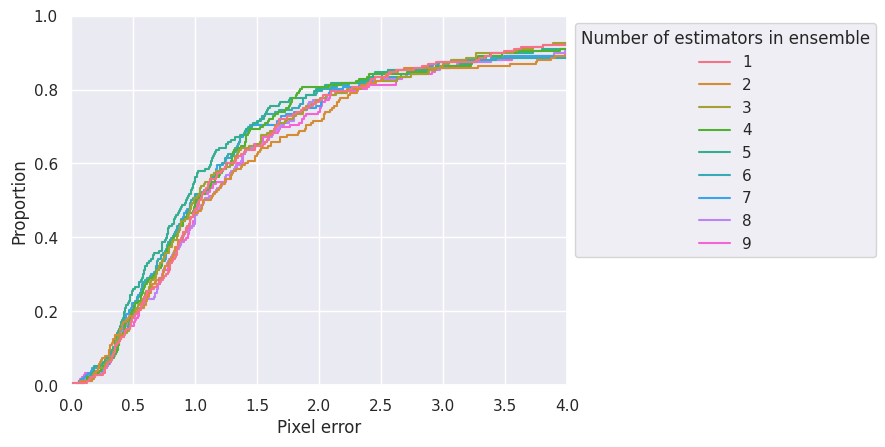

In [41]:
NUM_ENSEMBLES = 9
results_distances_ensemble_subset = results_distances_ensemble[results_distances_ensemble["Number of estimators in ensemble"] <= NUM_ENSEMBLES]

ax = sns.ecdfplot(
    data=results_distances_ensemble_subset, 
    x="Pixel error", 
    hue="Number of estimators in ensemble", 
    palette=sns.color_palette("husl", n_colors=NUM_ENSEMBLES)
)
ax.set_xlim(0, 4)
#ax.set_ylim(0.6, 1.0)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.savefig('ensembles.png', bbox_inches='tight', dpi=500)

In [42]:
ks_2samp(
    results_distances_ensemble[results_distances_ensemble["Number of estimators in ensemble"] == 5]["Pixel error"].to_numpy(),
    results_distances_ensemble[results_distances_ensemble["Number of estimators in ensemble"] == 1]["Pixel error"].to_numpy(),
    alternative="greater"
)

KstestResult(statistic=0.11931818181818182, pvalue=0.08171599372118733, statistic_location=0.7804995992009076, statistic_sign=1)

## Visualization

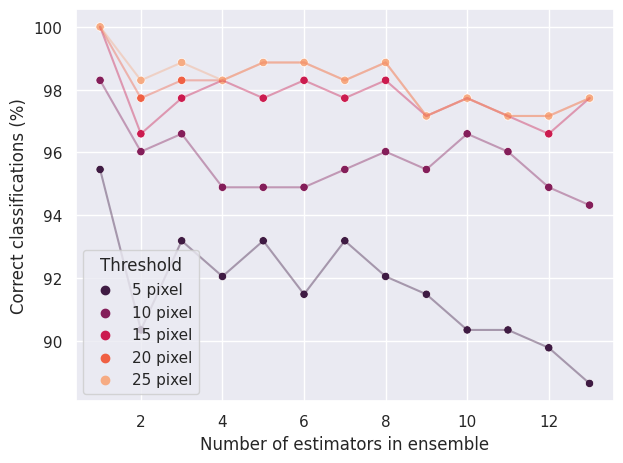

In [43]:
results_distances_error = None
thresholds = [5, 10, 15, 20, 25]
for threshold in thresholds:
    tmp = results_distances_ensemble[["Number of estimators in ensemble", "Pixel error"]].groupby("Number of estimators in ensemble").agg(lambda x: (x < threshold).sum() / len(x) * 100)
    threshold = f"{threshold} pixel"
    if results_distances_error is None:
        results_distances_error = tmp.rename(columns={"Pixel error": threshold})
    else:
        results_distances_error[threshold] = tmp

results_distances_error = pd.melt(results_distances_error.reset_index(), value_name="Correct classifications (%)", var_name="Threshold", ignore_index=True, id_vars="Number of estimators in ensemble")

palette = sns.color_palette("rocket", n_colors=len(thresholds))
ax = sns.scatterplot(results_distances_error, y="Correct classifications (%)", x="Number of estimators in ensemble", hue="Threshold", palette=palette)
ax = sns.lineplot(results_distances_error, y="Correct classifications (%)", x="Number of estimators in ensemble", hue="Threshold", palette=palette, alpha=0.4, legend=False)

ax.figure.tight_layout()
ax.figure.savefig("ensemble_correct_classification.png")

### Visualize spread

<Axes: xlabel='Spread', ylabel='Density'>

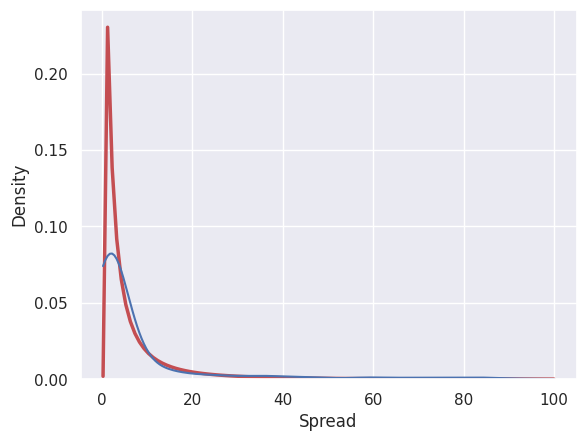

In [44]:
samples_global_spread = []
for file, values in results.groupby("File"):
    predictions = values[["X", "Y"]].to_numpy()
    median_value = geometric_median(predictions)
    median_spread = median_of_distances(predictions, median_value)
    samples_global_spread.append((file, median_spread))

samples_global_spread = pd.DataFrame.from_records(samples_global_spread, columns=["File", "Spread"])

fig, ax = plt.subplots()
xx = np.linspace(samples_global_spread["Spread"].min(), samples_global_spread["Spread"].max(), 100)
ax.plot(xx, lognorm.pdf(xx, *lognorm.fit(samples_global_spread["Spread"])), color="r", lw=2.5)
sns.kdeplot(data=samples_global_spread, x="Spread", ax=ax, cut=0)